In [1]:
import numpy as np
import os, re, glob 
from tqdm import tqdm
from matplotlib import pyplot as plt 
%matplotlib inline

import cv2
from tensorflow.keras.utils import img_to_array, array_to_img, load_img 
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger, EarlyStopping
from tensorflow.keras import Model

In [9]:
from google.colab import drive 
drive.mount('/content/drive') 
!unzip /content/drive/MyDrive/dataset256p.zip 

Mounted at /content/drive


In [2]:
def dataset():
    imagesPath = os.path.join('dataset256p', 'image', 'imgs', '*')
    masksPath = os.path.join('dataset256p', 'mask', 'imgs', '*')

    Images = glob.glob(imagesPath)
    Masks = glob.glob(masksPath)
    Images.sort()
    Masks.sort()

    X = np.zeros((len(Images), 256, 256, 3), dtype=np.float32)
    Y = np.zeros((len(Images), 256, 256, 1), dtype=np.bool_)

    n = 0
    for imagepath, maskpath in tqdm(zip(Images, Masks)):
        img = cv2.imread(imagepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
        mask = img_to_array(load_img(maskpath, color_mode='grayscale')) 
        X[n] = img
        Y[n] = mask
        n += 1

    X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.3, random_state=42) 

    # train_mean = np.mean(X_train,axis = (0,1,2,3))
    # train_std = np.std(X_train,axis = (0,1,2,3))
    # X_train = (X_train - train_mean)/(train_std+1e-7)

    # test_mean = np.mean(X_valid,axis=(0,1,2,3))
    # test_std = np.std(X_valid,axis = (0,1,2,3))
    # X_valid = (X_valid-test_mean)/(test_std+1e-7)

    del X, Y, Images, Masks

    return X_train, y_train, X_valid, y_valid


X_train, y_train, X_valid, y_valid = dataset() 

10015it [00:28, 354.85it/s]


In [3]:
print(len(X_train), len(X_valid)) 

7010 3005


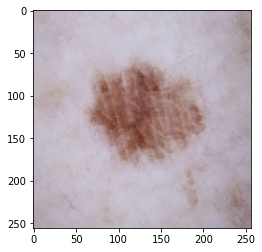

In [4]:
plt.imshow(X_train[2]) 
plt.show()

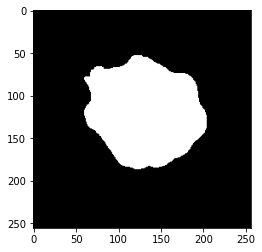

In [5]:
plt.imshow(y_train[2].reshape((256,256)), cmap='gray')
plt.show()

In [10]:
import shutil

def saveNumpyDatasetet():
  np.save('train_images.npy', X_train)
  np.save('test_images.npy', X_valid)
  np.save('train_labels.npy', y_train)
  np.save('test_labels.npy', y_valid) 

  shutil.copy("train_images.npy","/content/drive/MyDrive/segmentationData")
  shutil.copy("train_labels.npy","/content/drive/MyDrive/segmentationData")
  shutil.copy("test_images.npy","/content/drive/MyDrive/segmentationData")
  shutil.copy("test_labels.npy","/content/drive/MyDrive/segmentationData")

saveNumpyDatasetet()

In [2]:
X_train = np.load('train_images.npy') 
X_valid = np.load('test_images.npy') 
y_train = np.load('train_labels.npy') 
y_valid = np.load('test_labels.npy') 

In [3]:
def get_unet_model(dims):

    inputs = Input(dims)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
   

    up6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = Concatenate(axis=3)([conv4,up6])
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = Concatenate(axis=3)([conv3,up7])
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = Concatenate(axis=3)([conv2,up8])
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = Concatenate(axis=3)([conv1,up9])
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model 

In [4]:
model = get_unet_model((256,256,3)) 
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [5]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer = Adam(learning_rate = 1e-3), loss = 'binary_crossentropy', metrics = ['accuracy']) 

In [6]:
callbacks = [
  EarlyStopping(patience=10, verbose=1), 
  ReduceLROnPlateau(factor=0.5, cooldown=0, patience=6, min_lr=0.5e-6), 
  CSVLogger('Unetsegmodel_lr_e3_bs_8.csv'), 
  ModelCheckpoint("Unetsegmodel_lr_e3_bs_8.hdf5", monitor = 'val_loss',verbose = 1,save_best_only=True) 
]

In [7]:
model.fit(X_train, y_train, batch_size=8, epochs=25, verbose=1,validation_data=(X_valid, y_valid), shuffle=True, callbacks=callbacks) 

Epoch 1/25
877/877 [==============================] - ETA: 0s - loss: 0.2645 - accuracy: 0.8893
Epoch 1: val_loss improved from inf to 0.20420, saving model to Unetsegmodel_lr_e3_bs_8.hdf5
877/877 [==============================] - 106s 108ms/step - loss: 0.2645 - accuracy: 0.8893 - val_loss: 0.2042 - val_accuracy: 0.9189 - lr: 0.0010
Epoch 2/25
876/877 [============================>.] - ETA: 0s - loss: 0.1588 - accuracy: 0.9387
Epoch 2: val_loss improved from 0.20420 to 0.13476, saving model to Unetsegmodel_lr_e3_bs_8.hdf5
877/877 [==============================] - 90s 103ms/step - loss: 0.1588 - accuracy: 0.9387 - val_loss: 0.1348 - val_accuracy: 0.9474 - lr: 0.0010
Epoch 3/25
876/877 [============================>.] - ETA: 0s - loss: 0.1433 - accuracy: 0.9445
Epoch 3: val_loss improved from 0.13476 to 0.12988, saving model to Unetsegmodel_lr_e3_bs_8.hdf5
877/877 [==============================] - 90s 103ms/step - loss: 0.1433 - accuracy: 0.9445 - val_loss: 0.1299 - val_accuracy: 0.9

In [8]:
import shutil
def saveModel():
  shutil.copy("Unetsegmodel_lr_e3_bs_8.hdf5","/content/drive/MyDrive/segmentationData")
  shutil.copy("Unetsegmodel_lr_e3_bs_8.csv","/content/drive/MyDrive/segmentationData")

saveModel() 

In [24]:
model.load_weights('Unetsegmodel_lr_e3_bs_8.hdf5') 
model.save('/content/drive/MyDrive/segmentationData/model.hdf5') 

In [25]:
predictions = model.predict(X_valid[2].reshape((1,256,256,3))) 
predictions.shape 

1/1 [==============================] - 0s 19ms/step


(1, 256, 256, 1)

In [26]:
predictions = predictions.reshape((256,256))
results = predictions > 0.5
results.shape 

(256, 256)

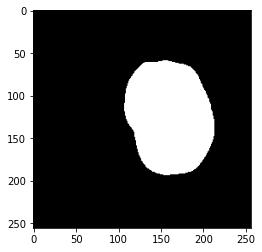

In [27]:
plt.imshow(results, cmap = "gray")

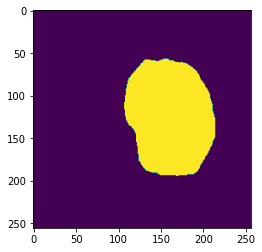

In [28]:
plt.imshow(y_valid[2].reshape((256,256)))